In [1]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#read files
import zipfile
with zipfile.ZipFile('customers.csv.zip', 'r') as z:
    f = z.open('customers.csv')
    customers = pd.read_csv(f)
    
with zipfile.ZipFile('articles.csv.zip', 'r') as z:
    f = z.open('articles.csv')
    articles = pd.read_csv(f)
    
with zipfile.ZipFile('transactions_train.csv.zip', 'r') as z:
    f = z.open('transactions_train.csv')
    transactions = pd.read_csv(f, parse_dates=['t_dat'])

In [3]:
def select_columns(df):
    return (df
            .iloc[:,:-1]
           )

def tweak_data(df):
    return (df
     .pipe(select_columns)
     .assign(FN = df.FN.fillna(0).astype(bool),
             Active = df.Active.fillna(0).astype(bool),
             fashion_news_frequency = lambda df: df.fashion_news_frequency.where(df.fashion_news_frequency != 'None', 'NONE').astype('category')
             )
     .dropna()
     .assign(club_member_status = df.club_member_status.astype('category'),
            age = df.age.astype('Int8'))
           )

In [8]:
def tweak_data_trns(df):
    return (df
     .assign(price = df.price.astype('float32'),
             sales_channel = 'store')
     .assign(sales_channel = lambda df: df.sales_channel.where(df.sales_channel_id == 1, 'online').astype('category')
             )
     .drop(columns=['sales_channel_id'])
           )

In [10]:
def tweak_data_arts(df):
    cols = ['article_id','product_type_name']
    return (df
     [cols]
     .assign(product_type = df.product_type_name.astype('category'),
             )
     )

In [12]:
def merge_dfs(customers, transactions, articles):
    return (
    pd.merge(pd.merge(tweak_data(customers), tweak_data_trns(transactions), on='customer_id'),
            tweak_data_arts(articles), on='article_id')
    )

In [13]:
df = (merge_dfs(customers, transactions, articles)
            .drop(columns=['article_id']))

In [14]:
df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,t_dat,price,sales_channel,section_name,product_type
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,False,False,ACTIVE,NONE,49,2018-12-27,0.044051,store,Kids Outerwear,Jacket
1,0209bfc5582b5c855952e5b43dc9c17bef921ca0f46b42...,False,False,ACTIVE,NONE,44,2018-10-03,0.061000,store,Kids Outerwear,Jacket
2,05d20eff33ec820d4330ee25cce4d0c35e8a305137caf0...,True,True,ACTIVE,Regularly,41,2019-12-17,0.033881,online,Kids Outerwear,Jacket
3,05fa492d5d182adb9dca7cc20be545d2dc8990606d2197...,True,False,ACTIVE,Regularly,41,2018-11-22,0.050831,store,Kids Outerwear,Jacket
4,060de711fa176fb5249bb39f0eceea040bde903f8b0434...,False,False,ACTIVE,NONE,45,2018-09-24,0.067780,online,Kids Outerwear,Jacket


# RFM Analysis

In [15]:
#Calculating Recency

df_recency = df.groupby(by='customer_id',
                        as_index=False)['t_dat'].max()
df_recency.columns = ['customer_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,customer_id,LastPurchaseDate,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,17
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,76
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,7
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,471
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,41


In [25]:
#Calculating Frequency. Customers buy more than 1 or more items per transaction so we group by date to avoid double counting

frequency_df = df.drop_duplicates().groupby(
    by=['customer_id', 't_dat'], as_index=False)['FN'].count()
frequency_df.columns = ['customer_id','t_dat','Frequency']
frequency_df = frequency_df.groupby(by=['customer_id'], as_index=False)['Frequency'].count()
frequency_df.columns = ['customer_id','Frequency']
frequency_df.head()

,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,10
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,23
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,7
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,6


In [26]:
#Calculating Monetary Value

monetary_df = df.groupby(by='customer_id', as_index=False)['price'].sum()
monetary_df.columns = ['customer_id', 'Monetary']
monetary_df.head()

,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.648983
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2.601932
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.704780
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.469695


In [27]:
#Merging all three columns in one dataframe


rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,17,10,0.648983
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,76,23,2.601932
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,7,7,0.704780
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,471,1,0.060983
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,41,6,0.469695


In [28]:
#Ranking Customer’s based upon their recency, frequency, and monetary score
#we normalize the rank of the customers


rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,17,10,0.648983,88.788867,79.081248,79.081248
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,76,23,2.601932,65.963996,94.195052,94.195052
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,7,7,0.704780,94.981945,70.761415,70.761415
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,471,1,0.060983,18.891831,16.156178,16.156178
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,41,6,0.469695,77.544570,67.050581,67.050581


In [29]:
#Calculating RFM score on a scale of 5 as "0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score"
#the weighting is custom

rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28*rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['customer_id', 'RFM_Score']].head(7)

,customer_id,RFM_Score
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,4.03
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,4.50
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,3.72
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.83
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,3.43
5,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,2.83
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,4.16


In [30]:
#Rating Customer based upon the RFM score
"""
rfm score >4.5 : Top Customer
4.5 > rfm score > 4 : High Value Customer
4>rfm score >3 : Medium value customer
3>rfm score>1.6 : Low-value customer
rfm score<1.6 :Lost Customer
"""

rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 4.5, "Top Customers",
                            (np.where(rfm_df['RFM_Score'] > 4, "High value Customer",
                            (np.where(rfm_df['RFM_Score'] > 3, "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6, 'Low Value Customers', 
                            'Lost Customers'))))))
rfm_df[['customer_id', 'RFM_Score', 'Customer_segment']].head(20)

,customer_id,RFM_Score,Customer_segment
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,4.03,High value Customer
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,4.50,High value Customer
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,3.72,Medium Value Customer
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.83,Lost Customers
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,3.43,Medium Value Customer
5,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,2.83,Low Value Customers
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,4.16,High value Customer
7,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,0.96,Lost Customers
8,00008469a21b50b3d147c97135e25b4201a8c58997f787...,0.72,Lost Customers
9,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,2.18,Low Value Customers


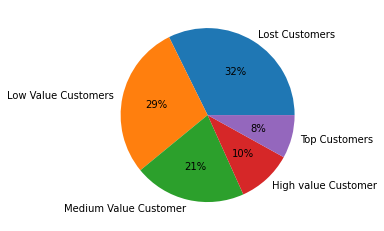

In [31]:
#Visualizing the customer segments

plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [32]:
df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,t_dat,price,sales_channel,section_name,product_type
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,False,False,ACTIVE,NONE,49,2018-12-27,0.044051,store,Kids Outerwear,Jacket
1,0209bfc5582b5c855952e5b43dc9c17bef921ca0f46b42...,False,False,ACTIVE,NONE,44,2018-10-03,0.061000,store,Kids Outerwear,Jacket
2,05d20eff33ec820d4330ee25cce4d0c35e8a305137caf0...,True,True,ACTIVE,Regularly,41,2019-12-17,0.033881,online,Kids Outerwear,Jacket
3,05fa492d5d182adb9dca7cc20be545d2dc8990606d2197...,True,False,ACTIVE,Regularly,41,2018-11-22,0.050831,store,Kids Outerwear,Jacket
4,060de711fa176fb5249bb39f0eceea040bde903f8b0434...,False,False,ACTIVE,NONE,45,2018-09-24,0.067780,online,Kids Outerwear,Jacket


In [33]:
df_by_sales_channel = (df.groupby(['customer_id', 'sales_channel']).agg({'FN':'count'})
 .pivot_table(index=['customer_id'], columns=['sales_channel'], values=['FN'])
['FN'])
df_by_sales_channel.columns = pd.Index(list(df_by_sales_channel.columns))
df_by_sales_channel

,online,store
customer_id,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,12,9
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,81,5
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,18,0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2,0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,11,2
...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,38,13
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,56,28
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,34,11


In [34]:
rfm_df[['customer_id', 'Customer_segment']].head()

,customer_id,Customer_segment
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,High value Customer
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,High value Customer
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Medium Value Customer
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,Lost Customers
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Medium Value Customer


In [35]:
merged_sales_chann = (df_by_sales_channel.reset_index()
 .merge(rfm_df[['customer_id', 'Customer_segment']], on='customer_id')
)

merged_sales_chann.head()

,customer_id,online,store,Customer_segment
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,12,9,High value Customer
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,81,5,High value Customer
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18,0,Medium Value Customer
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2,0,Lost Customers
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,11,2,Medium Value Customer


In [36]:
sales_channel = merged_sales_chann.groupby('Customer_segment').agg({'online':'sum', 'store':'sum'})
sales_channel

,online,store
Customer_segment,,
High value Customer,4808967,2345233
Lost Customers,1055512,435786
Low Value Customers,2793357,1025991
Medium Value Customer,4961879,2353972
Top Customers,8553092,3137783


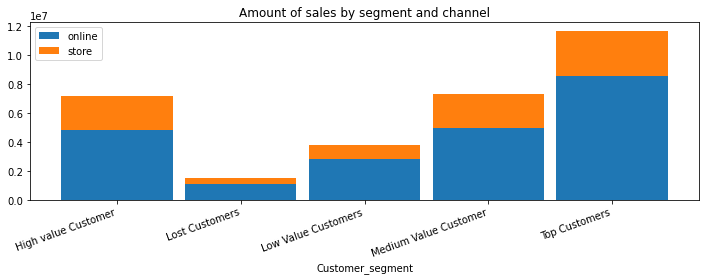

In [37]:
# plot data in stacked bar type
sales_channel.reset_index().plot(x='Customer_segment', kind='bar', stacked=True, width=0.9,
        title='Amount of sales by segment and channel')
plt.xticks(rotation=20, ha='right')
plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.show()

In [38]:
#The top customers are the ones who make the greatest amount of purchases online. They represent 8% of the total customers.

In [39]:
customers = (pd.merge(tweak_data(customers), rfm_df[['customer_id', 'Customer_segment']], on='customer_id')
)

In [40]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,Customer_segment
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,False,False,ACTIVE,NONE,49,High value Customer
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,False,False,ACTIVE,NONE,25,High value Customer
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,False,False,ACTIVE,NONE,24,Medium Value Customer
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,False,False,ACTIVE,NONE,54,Lost Customers
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,True,True,ACTIVE,Regularly,52,Medium Value Customer


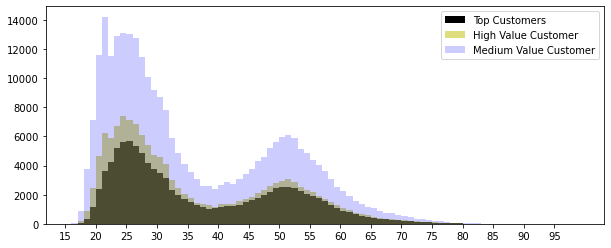

In [41]:
bins = np.arange(16, 100)
positions = [i for i in range(15, 100, 5)]
plt.hist(customers[customers['Customer_segment']=='Top Customers']['age'], bins, label='Top Customers', color='k')
plt.hist(customers[customers['Customer_segment']=='High value Customer']['age'], bins, alpha=0.5, label='High Value Customer', color='y')
plt.hist(customers[customers['Customer_segment']=='Medium Value Customer']['age'], bins, alpha=0.2, label='Medium Value Customer', color='b')
plt.legend(loc='upper right')
#ax1.set_xticks(positions)
plt.xticks(positions) 
plt.gcf().set_size_inches(10, 4)
plt.show()

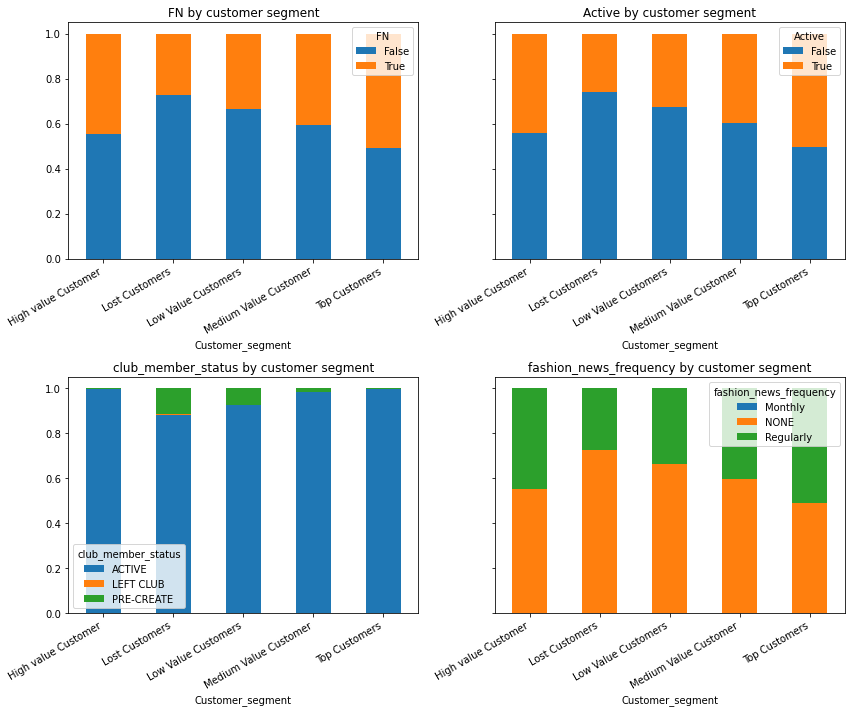

In [42]:
features = customers.columns[1:5]

fig,axs = plt.subplots(2,2,figsize=(12,10),sharey=True)

for ax,feat in zip(axs.flatten(),features):
    ((pd.crosstab(customers[feat],customers['Customer_segment'])) / (pd.crosstab(customers[feat],customers['Customer_segment']).sum())).T.plot.bar(stacked=True,ax=ax,legend=True,title=None)
    ax.set_title(f'{feat} by customer segment')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()

In [43]:
#Conclusions:
# 1) The age distribution of the customers do not vary by customer segment.
# 2) The highest the value of the customer, the more involved they are with the company (i.e. they are more active in their 
#    club member status, they receive fashion news more regularly and the a greater amount of them is subscribed to 
#    fashion newsletter). 
#   There are no surprises with respect to this.

In [51]:
#customers[['customer_id', 'Customer_segment', 'age']].to_csv('customers_mod.csv')